In [317]:
using DataFrames, CSV, StringEncodings, Dictionaries, Dates, StatsBase, HTTP, JSON, ProgressBars, GLM, Plots

In [203]:
database = joinpath("..", "Data")

years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]

dfs = []

for yearid = years
    datadir = joinpath(database, string(yearid))
    thisyear = DataFrame(CSV.File(joinpath(datadir, "final_format.csv")))
    thisyear.home_odds = string.(thisyear.home_odds)
    thisyear.away_odds = string.(thisyear.away_odds)
    push!(dfs, thisyear)
end

fullset = dfs[1]

for i = 2:length(dfs)
    fullset = vcat(fullset, dfs[i])
end



In [204]:
thisyear = DataFrame(CSV.File(joinpath(database, string(2022), "final_format.csv")));

In [205]:
fullset.home_odds = replace(fullset.home_odds, "-" => missing)
fullset.home_odds = replace(fullset.home_odds, "missing" => missing)
fullset.away_odds = replace(fullset.away_odds, "-" => missing);
fullset.away_odds = replace(fullset.away_odds, "missing" => missing);

In [206]:
dropmissing!(fullset)
filter!(row -> all(x -> !(x isa Number && isnan(x)), row), fullset);


In [207]:
# Convert money line to multiplier
fullset.home_odds = parse.(Int, fullset.home_odds)
fullset.away_odds = parse.(Int, fullset.away_odds)

12281-element Vector{Int64}:
 -130
  148
  142
  146
  106
  106
  126
 -166
 -156
  134
    ⋮
 -176
  110
 -101
 -125
  111
 -194
  110
 -119
  115

In [208]:
fullset.home_multiplier = (abs.(fullset.home_odds)/100).^(sign.(fullset.home_odds))
fullset.away_multiplier = (abs.(fullset.away_odds)/100).^(sign.(fullset.away_odds))

# favouritefactor is the ratio of away odds to home odds - measure of how
# favoured the home team is! Higher number = more favoured
fullset.favouritefactor = fullset.away_multiplier ./ fullset.home_multiplier;

In [209]:
Dates.Year.(fullset.game_date) .== Dates.Year(2025)

12281-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [210]:
# mode 1 = split training at the beginning of a year and test at the end
# mode 2 = split years up to yr are training all later are test
mode = 2
yr = 2023

if mode == 1
    trainset = fullset[(Dates.Year.(fullset.game_date) .== Dates.Year(yr)) .& (Dates.month.(fullset.game_date) .< 8), :]
    testset = fullset[(Dates.Year.(fullset.game_date) .== Dates.Year(yr)) .& (Dates.month.(fullset.game_date) .>= 8), :]
elseif mode == 2
    trainset = fullset[(Dates.Year.(fullset.game_date) .<= Dates.Year(yr)) , :]
    testset = fullset[(Dates.Year.(fullset.game_date) .> Dates.Year(yr)), :]
end

4184×37 DataFrame
  Row │ game_pk  game_date   home_odds  home_id  home_name  home_winner  home_ ⋯
      │ Int64    Date        Int64      Int64    String3    Bool         Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  744795  2024-09-25       -105      120  WSH              false        ⋯
    2 │  744796  2024-09-26        145      120  WSH              false
    3 │  744797  2024-09-27        150      120  WSH               true
    4 │  744798  2024-09-29        145      120  WSH              false
    5 │  744799  2024-09-28        180      120  WSH               true        ⋯
    6 │  744800  2024-09-13       -150      120  WSH               true
    7 │  744801  2024-09-15       -175      120  WSH               true
    8 │  744802  2024-09-24        135      120  WSH              false
  ⋮   │    ⋮         ⋮           ⋮         ⋮         ⋮           ⋮             ⋱
 4178 │  778477  2025-04-02       -111      158  MIL               true        ⋯
 4179 │  778479  2025-04-02        111      139  TB               false
 4180 │  778480  2025-04-02       -124      113  CIN              false
 4181 │  778481  2025-04-02        170      146  MIA              false
 4182 │  778482  2025-04-02       -320      143  PHI               true        ⋯
 4183 │  778483  2025-04-02        106      110  BAL              false
 4184 │  778484  2025-04-02       -117      147  NYY              false
                                                31 columns and 4169 rows omitted

# This section looks at tuning logistic regression

In [211]:
fm = @formula(home_winner ~ home_last5_o_hardhit_diff + home_last5_o_launch_angle + home_last5_o_launch_speed_diff +
                            home_last5_o_xwoba_diff + home_last_p_hardhit_diff + home_last_p_launch_angle + home_last_p_launch_speed_diff +
                            home_last_p_xwoba_diff + away_last5_o_launch_angle +
                            + away_last_p_launch_angle + favouritefactor + home_win_pct_to_date + 
                            away_win_pct_to_date)

logit = glm(fm, trainset, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

home_winner ~ 1 + home_last5_o_hardhit_diff + home_last5_o_launch_angle + home_last5_o_launch_speed_diff + home_last5_o_xwoba_diff + home_last_p_hardhit_diff + home_last_p_launch_angle + home_last_p_launch_speed_diff + home_last_p_xwoba_diff + away_last5_o_launch_angle + away_last_p_launch_angle + favouritefactor + home_win_pct_to_date + away_win_pct_to_date

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                       Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                     -0.169322     0.1422      -1.19    0.2338  -0.448029    

In [212]:
# Retrain with only significant to 95%

fm = @formula(home_winner ~ home_last5_o_launch_angle + 
                            home_last_p_launch_speed_diff +
                            favouritefactor +
                            home_win_pct_to_date + away_win_pct_to_date)

logit = glm(fm, trainset, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

home_winner ~ 1 + home_last5_o_launch_angle + home_last_p_launch_speed_diff + favouritefactor + home_win_pct_to_date + away_win_pct_to_date

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────
                                     Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    -0.236566    0.116772    -2.03    0.0428  -0.465435    -0.00769722
home_last5_o_launch_angle       0.0124664   0.00425619   2.93    0.0034   0.00412441   0.0208084
home_last_p_launch_speed_diff  -0.00839617  0.00610823  -1.37    0.1693  -0.0203681    0.00357574
favouritefactor       

In [213]:
pred = predict(logit, trainset)

accs = []

rocs = 0.1:0.01:0.9

for roc = rocs

    homewins = pred .>= roc

    predictiondf = DataFrame(y_actual = trainset.home_winner,
                            y_pred = homewins,
                            y_prob = pred)

    mean_accuracy = mean(predictiondf.y_actual .== predictiondf.y_pred)

    push!(accs, mean_accuracy)
end
println("Best Training set Accuracy: " * string(maximum(accs)))

bestroc = rocs[argmax(accs)]

pred = predict(logit, testset)

homewins = pred .>= bestroc

predictiondf = DataFrame(y_actual = testset.home_winner,
                        y_pred = homewins,
                        y_prob = pred)

mean_accuracy = mean(predictiondf.y_actual .== predictiondf.y_pred)

println("Test Accuracy: " * string(mean_accuracy))

Best Training set Accuracy: 0.5867605285908362
Test Accuracy: 0.5499521988527725


# This section looks at Training OCT's/other IAI tools

In [229]:
# features = [:home_id, :home_last5_o_hardhit, :home_last5_o_launch_angle, :home_last5_o_launch_speed, 
#                 :home_last5_o_xwoba, :home_last_p_hardhit, :home_last_p_launch_angle, :home_last_p_launch_speed, 
#                 :home_last_p_xwoba, :away_id, :away_last5_o_hardhit, :away_last5_o_launch_angle, :away_last5_o_launch_speed, 
#                 :away_last5_o_xwoba, :away_last_p_hardhit, :away_last_p_launch_angle, :away_last_p_launch_speed, :away_last_p_xwoba,
#                 :favouritefactor, :home_win_pct_to_date, :away_win_pct_to_date]

features = [:home_id, :home_last5_o_hardhit_diff, :home_last5_o_launch_angle, :home_last5_o_launch_speed_diff, 
                :home_last5_o_xwoba_diff, :home_last_p_hardhit_diff, :home_last_p_launch_angle, :home_last_p_launch_speed_diff, 
                :home_last_p_xwoba_diff, :away_id, :away_last5_o_launch_angle, :away_last_p_launch_angle, 
                :favouritefactor, :home_win_pct_to_date, :away_win_pct_to_date]

featurestraining = trainset[!, features]
featurestesting = testset[!, features]

winnertraining = trainset.home_winner
winnertest = testset.home_winner

# Create the validation and training sets
seed = 15095
(X_train, y_train), (X_valid, y_valid) = IAI.split_data(:classification, featurestraining, 
                                            winnertraining, seed=seed, train_proportion=0.7);

In [ ]:
maxDepths = [2,4,6]
minBuckets = [20, 50, 100, 200]
criteria = [:gini, :entropy, :misclassification]

grid = IAI.GridSearch(IAI.OptimalTreeClassifier(
                    random_seed = seed,
                    criterion=:gini,
                ),
            max_depth=maxDepths,
            minbucket=minBuckets,
            validation_criterion = :misclassification)
            # criterion=criteria, 
            # validation_criterion = :auc)

IAI.fit!(grid, X_train, y_train, X_valid, y_valid)
# IAI.fit_cv!(grid, featurestraining, winnertraining)

# Get the best learner
best_params = IAI.get_learner(grid)
# IAI.write_html("ReportAssets/TreePart2ii.html", best_params)

# Get AUC score for validation data (name the variable holding the AUC score as `val_auc`)
val_auc = IAI.score(grid, featurestraining, winnertraining, criterion=:misclassification)

0.5925651475855255

In [245]:
best_params

Fitted OptimalTreeClassifier:
  1) Split: favouritefactor < 1.041
    2) Split: favouritefactor < 0.5686
      3) Predict: false (62.44%), [891,536], 1427 points, error 0.6619
      4) Predict: false (53.58%), [1025,888], 1913 points, error 0.6906
    5) Split: favouritefactor < 3.63
      6) Predict: true (57.90%), [1620,2228], 3848 points, error 0.6806
      7) Predict: true (71.95%), [255,654], 909 points, error 0.5935

In [246]:
test_acc = IAI.score(grid, featurestesting, winnertest, criterion=:misclassification)

0.5657265774378586

# In this section we look at fitting a policy tree

We do so by
- augmenting the dataset with five potential "treatments"
    1. Big Bet ($100) on home team
    2. Small Bet ($10) on home team
    3. No Bet
    4. Small Bet ($10) on away team
    5. Big Bet ($100) on away team

- Training a two step, doubly-robust prescriptive tree to predict the best bet to make

In [267]:
# We define positive bet as bet on home team, negative, bet on away
bets = [-100, -10, 0, 10, 100]

alldf = DataFrame()

for i = 1:length(bets)
    bet = bets[i]

    betdf = copy(fullset)

    betdf.bet .= bet;
    
    home_return = abs.(betdf.bet) .* (1 .+ betdf.home_multiplier)
    away_return = abs.(betdf.bet) .* (1 .+ betdf.away_multiplier)

    bet_home = bet > 0;

    won_bet = .!(xor.(bet_home, betdf.home_winner))

    betdf.return = won_bet .* (bet_home .* home_return + !bet_home .* away_return) .- 
                    .!(won_bet) .* abs(bet)

    if i ==1
        alldf = copy(betdf)
    else
        alldf = vcat(alldf, betdf)
    end
end

alldf[!, [:home_odds, :home_multiplier, :home_winner, :away_odds, :away_multiplier, :bet, :return]]

61405×7 DataFrame
   Row │ home_odds  home_multiplier  home_winner  away_odds  away_multiplier   ⋯
       │ Int64      Float64          Bool         Int64      Float64           ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │       114         1.14            false       -130         0.769231   ⋯
     2 │      -174         0.574713         true        148         1.48
     3 │      -164         0.609756        false        142         1.42
     4 │      -168         0.595238        false        146         1.46
     5 │      -122         0.819672         true        106         1.06       ⋯
     6 │      -122         0.819672        false        106         1.06
     7 │      -144         0.694444        false        126         1.26
     8 │       144         1.44             true       -166         0.60241
   ⋮   │     ⋮             ⋮              ⋮           ⋮             ⋮          ⋱
 61399 │      -111         0.900901         true       -101         0.990099   ⋯
 61400 │       111         1.11            false       -125         0.8
 61401 │      -124         0.806452        false        111         1.11
 61402 │       170         1.7             false       -194         0.515464
 61403 │      -320         0.3125           true        110         1.1        ⋯
 61404 │       106         1.06            false       -119         0.840336
 61405 │      -117         0.854701        false        115         1.15
                                                2 columns and 61390 rows omitted

In [276]:
# mode 1 = split training at the beginning of a year and test at the end
# mode 2 = split years up to yr are training all later are test
mode = 2
yr = 2023

if mode == 1
    trainset = alldf[(Dates.Year.(alldf.game_date) .== Dates.Year(yr)) .& (Dates.month.(alldf.game_date) .< 8), :]
    testset = alldf[(Dates.Year.(alldf.game_date) .== Dates.Year(yr)) .& (Dates.month.(fullsalldfet.game_date) .>= 8), :]
elseif mode == 2
    trainset = alldf[(Dates.Year.(alldf.game_date) .<= Dates.Year(yr)) , :]
    testset = alldf[(Dates.Year.(alldf.game_date) .> Dates.Year(yr)), :]
end

ogheight = Int(size(fullset, 1) * (size(trainset, 1) / size(alldf, 1)))

8097

In [ ]:
reward_lnr = IAI.NumericRegressionRewardEstimator(
    propensity_estimator=IAI.RandomForestRegressor(),
    outcome_estimator=IAI.RandomForestRegressor(),
    reward_estimator=:doubly_robust,
    propensity_min_value=0.1,
    random_seed=seed,
)

train_predictions, train_reward_score = IAI.fit_predict!(
    reward_lnr, trainset[!, features], trainset[!, :bet], trainset[!, :return], bets)
train_rewards = train_predictions[!, :reward]

40485×5 DataFrame
   Row │ -100        -10        0         10         100
       │ Float64     Float64    Float64   Float64    Float64
───────┼─────────────────────────────────────────────────────────
     1 │  678.804     6.24304   2.55081    1.27289      29.6548
     2 │ -630.436    -1.58755   1.74069    4.09584      69.9876
     3 │ 1061.18      5.02575   2.75603    3.3293       32.5267
     4 │  996.421     7.93572   2.16103    0.645149    -10.4499
     5 │ -740.168     4.29383   2.16483    3.11874      57.4922
     6 │  800.479     6.92968   2.62029    3.01928       3.00209
     7 │ 1054.44      6.23666   2.49451    0.850776     14.2265
     8 │ -631.681     2.41364   2.97746    4.54129      29.4545
   ⋮   │     ⋮           ⋮         ⋮          ⋮           ⋮
 40479 │   24.1959   -0.218735  0.604762   3.06793     892.899
 40480 │   26.5606    0.174969  1.41207    4.23208     567.937
 40481 │   40.2239    1.53371   1.47751    1.1192     -843.42
 40482 │   16.4826    3.22164   3.60646    5.98863     785.147
 40483 │   44.5677    3.01471   1.30813    2.07316    -736.778
 40484 │   33.1285   -2.58539   2.0962     5.89996     576.251
 40485 │   53.2761    4.25075   3.85494    6.21442   -1148.56
                                               40470 rows omitted

In [282]:
train_predictions[:reward][[1, 1 + ogheight, 1 + 2*ogheight,
                            1 + 3*ogheight, 1 + 4*ogheight,], :]

5×5 DataFrame
 Row │ -100      -10       0          10          100
     │ Float64   Float64   Float64    Float64     Float64
─────┼──────────────────────────────────────────────────────
   1 │ 678.804    6.24304    2.55081    1.27289     29.6548
   2 │  71.0683  54.4503    24.7648     2.48999     29.389
   3 │  67.8092  -5.57727   -4.68794   -1.38343     12.1549
   4 │  71.0683   2.87857  -15.8281   -39.3653      29.389
   5 │  67.3966   5.12903    1.86422    0.310768  -746.814

In [272]:
train_reward_score[:propensity]

Dict{String, Float64} with 5 entries:
  "-100" => -0.0516202
  "10"   => -0.0485793
  "0"    => -0.0493462
  "-10"  => -0.0493213
  "100"  => -0.0481798

In [284]:
grid = IAI.GridSearch(
    IAI.OptimalTreePolicyMaximizer(
        random_seed=seed,
    ),
    max_depth=maxDepths,
    minbucket=minBuckets
)
IAI.fit!(grid, trainset[!, features], train_rewards)

All Grid Results:

 Row │ minbucket  max_depth  cp           train_score  valid_score  rank_valid_score
     │ Int64      Int64      Float64      Float64      Float64      Int64
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │        20          2  0.000374107   0.00590812   0.00210016                 9
   2 │        20          4  3.94977e-5    0.0100193    0.00298215                 8
   3 │        20          6  9.66909e-6    0.0162246    0.00617756                 1
   4 │        50          2  0.000374107   0.00590812   0.00210016                10
   5 │        50          4  0.000133851   0.00945943   0.00301398                 7
   6 │        50          6  1.75866e-5    0.0148166    0.0054945                  2
   7 │       100          2  0.000374107   0.00590812   0.00210016                11
   8 │       100          4  4.13443e-5    0.00949761   0.00332328                 6
   9 │       100          6  3.96242e-6    0.0146774    0.00526788                 3
  10 │       200          2  0.000374107   0.00590812   0.00210016                12
  11 │       200          4  5.61724e-5    0.00949965   0.00352278                 5
  12 │       200          6  1.5191e-5     0.0138201    0.00483395                 4

Best Params:
  minbucket => 20
  cp => 9.669091786679296e-6
  max_depth => 6

Best Model - Fitted OptimalTreePolicyMaximizer:
  1) Split: home_last5_o_hardhit_diff < -3.351
    2) Split: away_win_pct_to_date < 0.4899
      3) Split: home_last5_o_xwoba_diff < 0.0127
        4) Split: home_id < 113.5
          5) Split: away_win_pct_to_date < 0.3291
            6) Prescribe: -100, 90 points, error 2466.3
            7) Split: away_last5_o_launch_angle < 11.6
              8) Prescribe: 100, 285 points, error 2499.2
              9) Prescribe: -100, 400 points, error 2510
          10) Split: home_last_p_hardhit_diff < 2.022
            11) Split: home_last_p_launch_angle < 4.1
              12) Prescribe: -100, 60 points, error 2473.5
              13) Prescribe: 100, 1470 points, error 2507.1
            14) Split: home_last_p_xwoba_diff < 0.04178
              15) Prescribe: 100, 590 points, error 2528
              16) Prescribe: -100, 245 points, error 2486.9
        17) Split: home_last_p_launch_angle < 10.26
          18) Split: home_last_p_xwoba_diff < 0.0466
            19) Split: favouritefactor < 4.754
              20) Prescribe: 100, 220 points, error 2482.2
              21) Prescribe: -100, 40 points, error 2422.7
            22) Prescribe: -100, 20 points, error 2479.9
          23) Split: away_last_p_launch_angle < 19.18
            24) Split: away_win_pct_to_date < 0.4836
              25) Prescribe: -100, 795 points, error 2507.3
              26) Prescribe: 100, 50 points, error 2434
            27) Prescribe: 100, 25 points, error 2489.1
      28) Split: home_last5_o_launch_speed_diff < -0.83
        29) Split: home_last_p_xwoba_diff < 0.08408
          30) Split: away_id < 109.5
            31) Split: home_last_p_launch_speed_diff < 0.5806
              32) Prescribe: 100, 85 points, error 2481.9
              33) Prescribe: -100, 85 points, error 2516.4
            34) Split: home_last_p_launch_speed_diff < -6.519
              35) Prescribe: 100, 40 points, error 2410.2
              36) Prescribe: -100, 6035 points, error 2528
          37) Split: home_last_p_hardhit_diff < 12.79
            38) Split: favouritefactor < 0.6275
              39) Prescribe: -100, 165 points, error 2484.5
              40) Prescribe: 100, 85 points, error 2453.7
            41) Split: away_id < 111.5
              42) Prescribe: -100, 30 points, error 2502
              43) Prescribe: 100, 155 points, error 2424.8
        44) Split: favouritefactor < 0.3112
          45) Split: away_win_pct_to_date < 0.6238
            46) Split: home_last_p_launch_angle < 8.851
              47) Prescribe: 100, 20 points, error 2517.6
              48) Prescribe: -100, 120 points,

In [307]:
# test_bets = IAI.predict(grid, testset[1:(ogheight - 1), features])

res = testset[1:(ogheight - 1), [:game_date, :home_winner, :home_odds, :home_multiplier, :away_odds, :away_multiplier]]
res.pred_bet = parse.(Int, test_bets)

bethome = sign.(res.pred_bet) .== 1

res.won_bet = .!(xor.(bethome, res.home_winner))

home_return = abs.(res.pred_bet) .* (1 .+ res.home_multiplier)
away_return = abs.(res.pred_bet) .* (1 .+ res.away_multiplier)

res.return = res.won_bet .* (bethome .* home_return + .!(bethome) .* away_return) .- 
                    .!(res.won_bet) .* abs.(res.pred_bet)

res


8096×9 DataFrame
  Row │ game_date   home_winner  home_odds  home_multiplier  away_odds  away_m ⋯
      │ Date        Bool         Int64      Float64          Int64      Float6 ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 2024-09-25        false       -105         0.952381       -115         ⋯
    2 │ 2024-09-26        false        145         1.45           -175
    3 │ 2024-09-27         true        150         1.5            -185
    4 │ 2024-09-29        false        145         1.45           -175
    5 │ 2024-09-28         true        180         1.8            -225         ⋯
    6 │ 2024-09-13         true       -150         0.666667        125
    7 │ 2024-09-15         true       -175         0.571429        145
    8 │ 2024-09-24        false        135         1.35           -165
  ⋮   │     ⋮            ⋮           ⋮             ⋮             ⋮             ⋱
 8090 │ 2025-04-26         true       -225         0.444444        225         ⋯
 8091 │ 2025-04-26         true       -150         0.666667        132
 8092 │ 2025-04-26        false       -220         0.454545        190
 8093 │ 2025-04-26         true       -119         0.840336        106
 8094 │ 2025-04-26         true        120         1.2            -130         ⋯
 8095 │ 2025-04-26         true       -115         0.869565        115
 8096 │ 2025-04-27         true       -166         0.60241         156
                                                 4 columns and 8081 rows omitted

In [315]:
column_names = ["Date", "Bank", "Amt_Wagered", "Daily_Profit"]
budgetdf = DataFrame([name => [] for name in column_names])

todaydate = Date(2024, 1, 1)

budget = 2000

while Dates.Year(todaydate) <= Dates.Year(2025)

    todayset = res[res.game_date .== todaydate, :]

    wagered = sum(abs.(todayset.pred_bet))
    profit = sum(todayset.return)



    r = [todaydate, budget, wagered, profit]
    
    push!(budgetdf, r)

    budget = budget + profit

    todaydate = todaydate + Dates.Day(1)
end

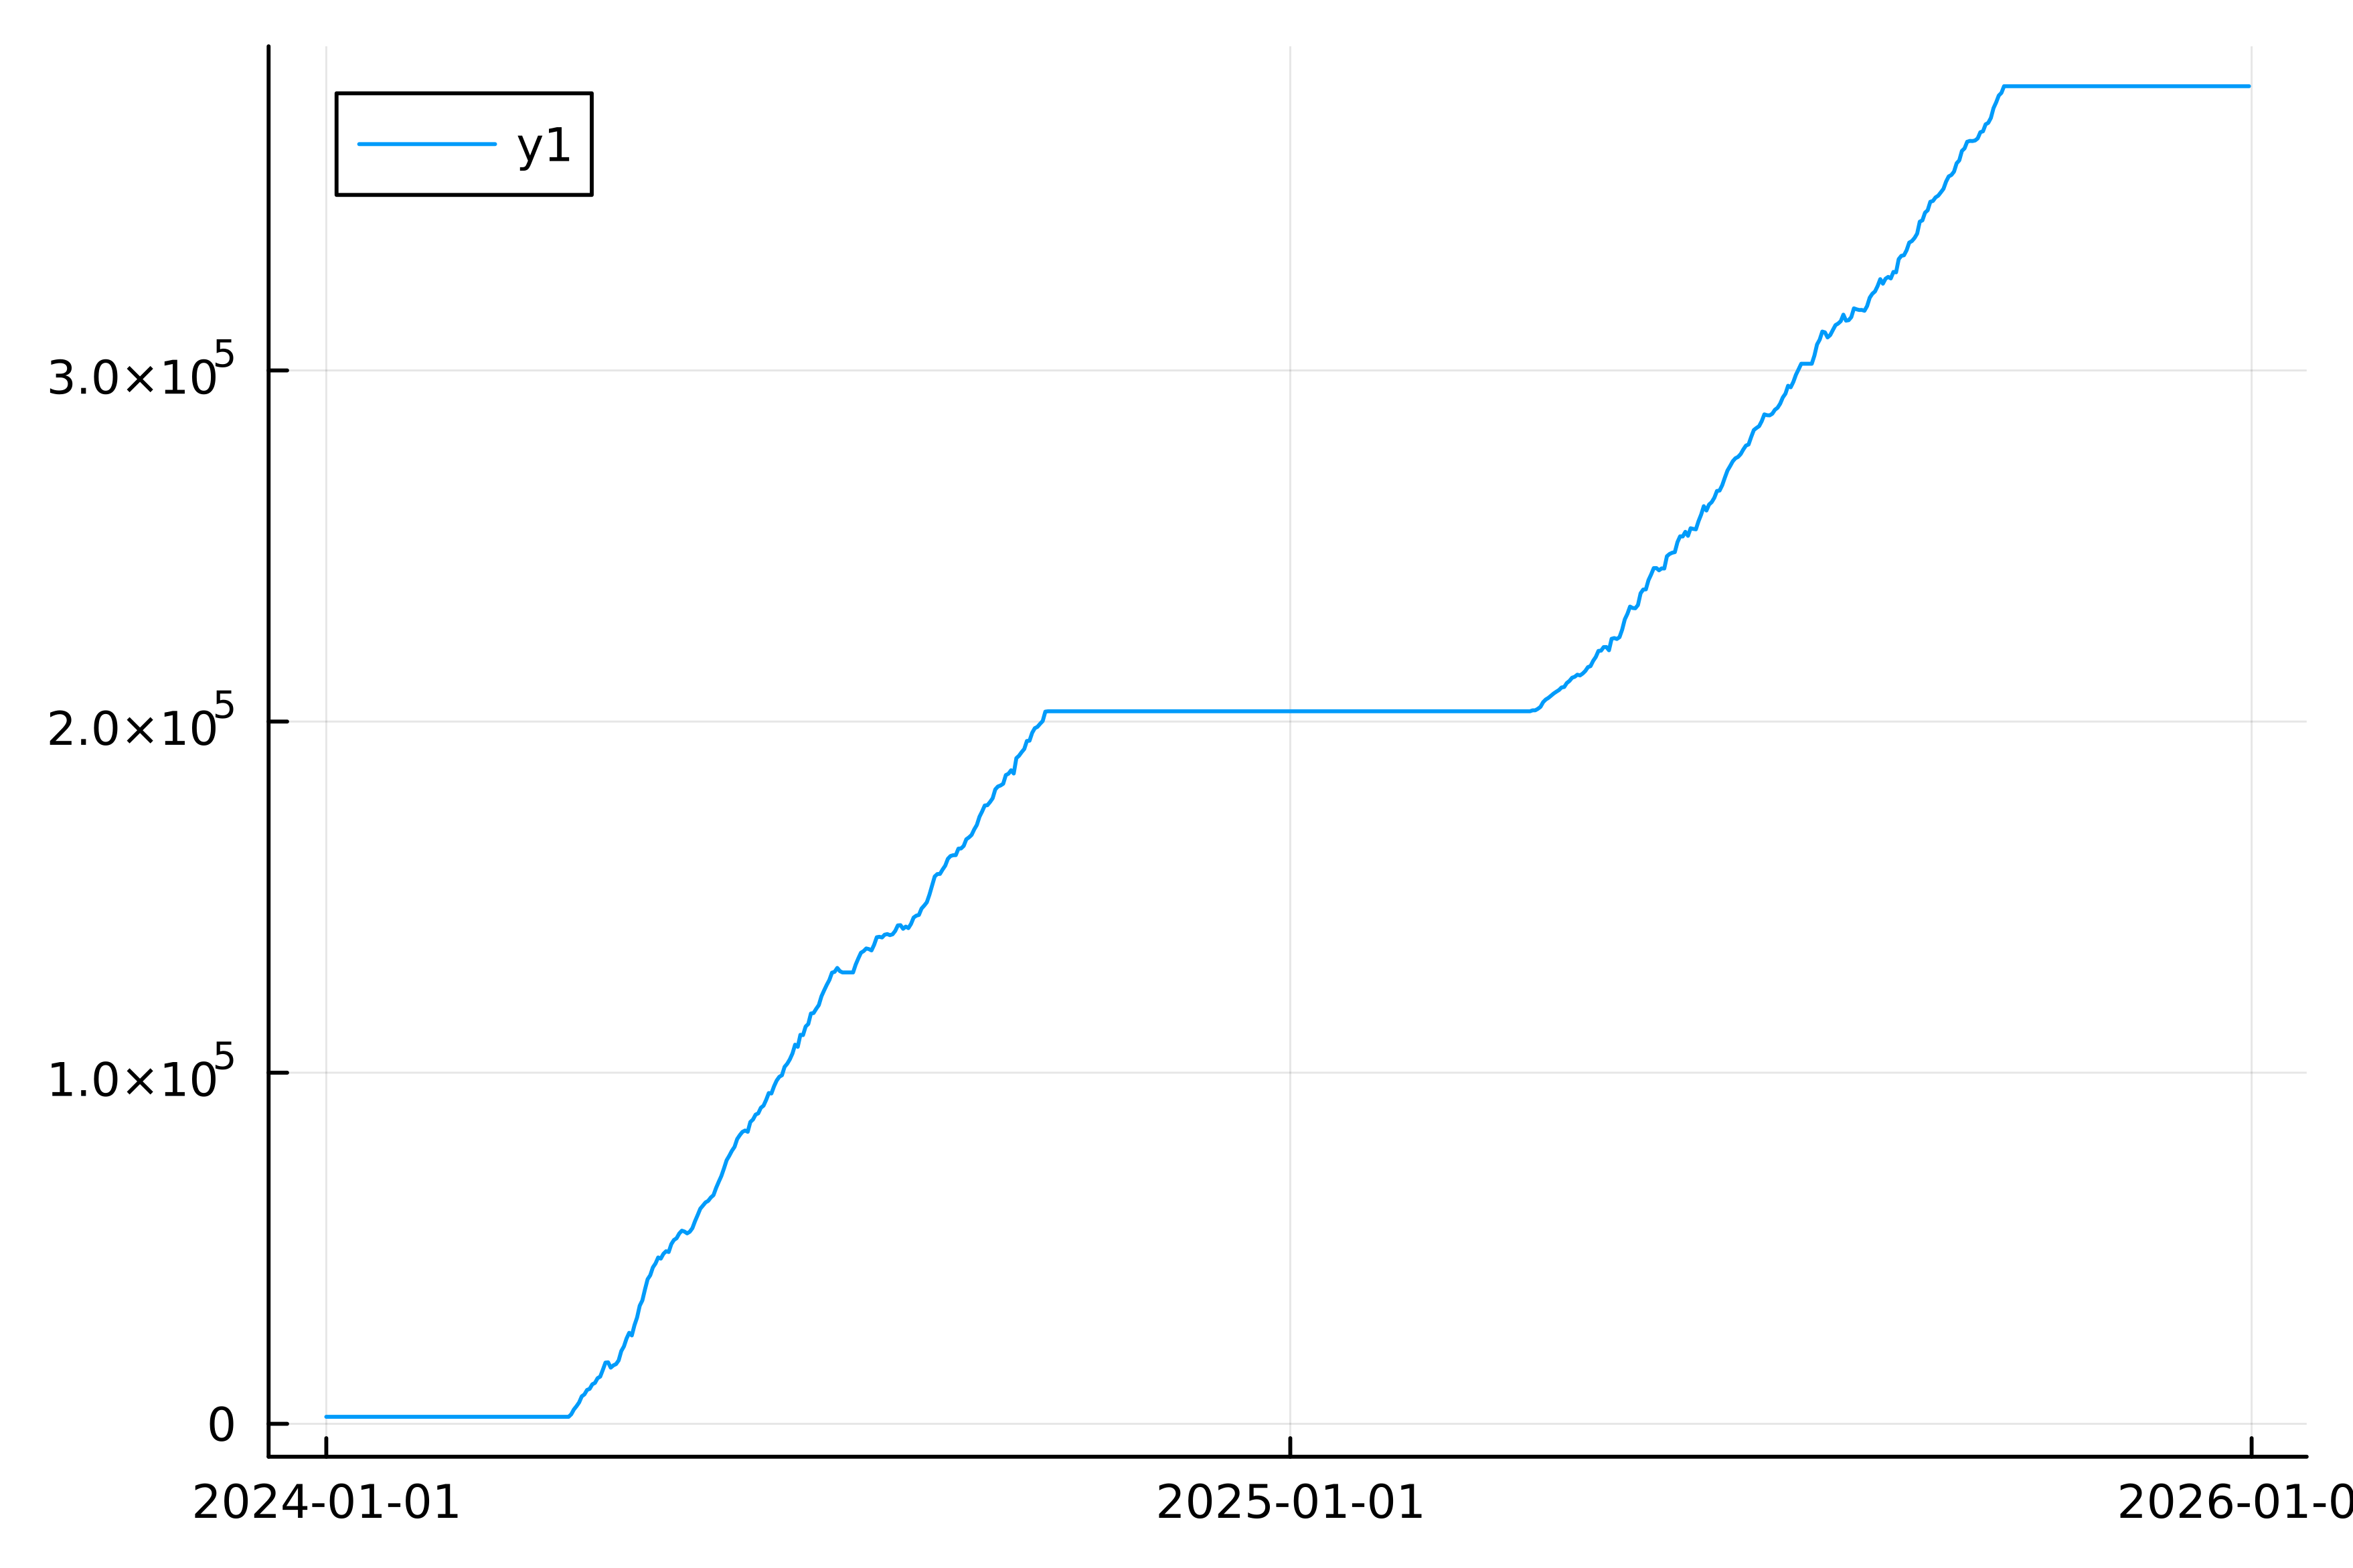

In [318]:
plot(budgetdf.Date, budgetdf.Bank)